# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [ ]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=191ap4cT6K0Yhe8k2IRN7fnd7tOELolBp'
!unzip 'SMAI_A2_2024.zip'
!mv SMAI_A2_2024/* ./
!rm -r SMAI_A2_2024
!rm SMAI_A2_2024.zip





Downloading...
From (original): https://drive.google.com/uc?id=191ap4cT6K0Yhe8k2IRN7fnd7tOELolBp
From (redirected): https://drive.google.com/uc?id=191ap4cT6K0Yhe8k2IRN7fnd7tOELolBp&confirm=t&uuid=2b98b8c0-14ce-4b77-a6c0-5c63505e1c86
To: /content/SMAI_A2_2024.zip
100% 119M/119M [00:00<00:00, 124MB/s]
Archive:  SMAI_A2_2024.zip
   creating: SMAI_A2_2024/
  inflating: SMAI_A2_2024/train_test_index.pickle  
  inflating: SMAI_A2_2024/training_3digits.hdf5  
  inflating: SMAI_A2_2024/testing_3digits_part2.hdf5  
  inflating: SMAI_A2_2024/testing_3digits_part1.hdf5  
  inflating: SMAI_A2_2024/product_reviews.csv  
  inflating: SMAI_A2_2024/roberta_embeds.npy.gz  


In [ ]:

!gdown 'https://drive.google.com/uc?id=1TM2ccUlN0WxnI9n4I2TiTOq7BSPA85Z-'
!unzip 'content.zip'
!mv content/* ./
!rm -r content
!rm content.zip

Downloading...
From: https://drive.google.com/uc?id=1TM2ccUlN0WxnI9n4I2TiTOq7BSPA85Z-
To: /content/content.zip
100% 720k/720k [00:00<00:00, 9.98MB/s]
Archive:  content.zip
   creating: content/
   creating: content/frames/
   creating: content/results/
   creating: content/videos/
  inflating: content/videos/traffic.gif  


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [ ]:


from google.colab.patches import cv2_imshow




### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [ ]:
import numpy as np

class GaussianMixture2:
    def __init__(self, n_components=1, covariance_type='full', random_state=None, max_iter=100, tol=1e-3):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol

        if covariance_type not in ['full', 'diag']:
            raise ValueError("covariance_type must be 'full' or 'diag'")

    def _initialize_parameters(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        self.weights_ = np.full(self.n_components, 1.0 / self.n_components)
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]

        if self.covariance_type == 'full':
            self.covariances_ = np.array([np.cov(X.T) for _ in range(self.n_components)])
        elif self.covariance_type == 'diag':
            self.covariances_ = np.array([np.diag(np.var(X, axis=0)) for _ in range(self.n_components)])

    def _e_step(self, X):
        n_samples, _ = X.shape
        self.posteriors_ = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            self.posteriors_[:, k] = self.weights_[k] * self._multivariate_normal(X, self.means_[k], self.covariances_[k])

        self.posteriors_ /= np.sum(self.posteriors_, axis=1, keepdims=True)

    def _m_step(self, X):
        n_samples, _ = X.shape

        for k in range(self.n_components):
            weight_sum = np.sum(self.posteriors_[:, k], axis=0)
            self.weights_[k] = weight_sum / n_samples
            self.means_[k] = np.sum(X * self.posteriors_[:, k][:, np.newaxis], axis=0) / weight_sum

            if self.covariance_type == 'full':
                cov = (X - self.means_[k]).T @ (X - self.means_[k]) / weight_sum
                self.covariances_[k] = cov + self.tol * np.eye(X.shape[1])
            elif self.covariance_type == 'diag':
                cov = np.diag(np.sum(self.posteriors_[:, k] * np.square(X - self.means_[k]), axis=0) / weight_sum)
                self.covariances_[k] = cov + self.tol

    def _multivariate_normal(self, X, mean, covariance):
        n_features = X.shape[1]
        det = np.linalg.det(covariance)
        norm_const = 1.0 / ((2 * np.pi) ** (n_features / 2) * np.sqrt(det + self.tol))
        inv_cov = np.linalg.pinv(covariance)
        exp = np.exp(-0.5 * np.sum((X - mean) @ inv_cov * (X - mean), axis=1))
        return norm_const * exp

    def fit(self, X):
        self._initialize_parameters(X)

        for _ in range(self.max_iter):
            prev_weights = np.copy(self.weights_)
            prev_means = np.copy(self.means_)
            prev_covariances = np.copy(self.covariances_)

            self._e_step(X)
            self._m_step(X)

            diff_weights = np.linalg.norm(self.weights_ - prev_weights)
            diff_means = np.linalg.norm(self.means_ - prev_means)
            diff_covariances = np.linalg.norm(self.covariances_ - prev_covariances)

            if diff_weights < self.tol and diff_means < self.tol and diff_covariances < self.tol:
                break

    def predict(self, X):
        n_samples, _ = X.shape
        posteriors = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            posteriors[:, k] = self.weights_[k] * self._multivariate_normal(X, self.means_[k], self.covariances_[k])

        return np.argmax(posteriors, axis=1)


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

#### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

#### Extract Background Image from the trained model

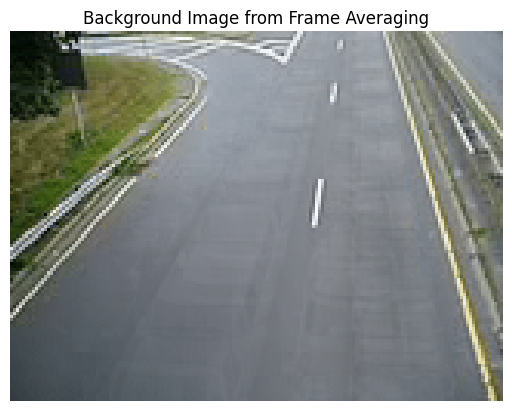

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

height, width, channels = train_frames.shape[1], train_frames.shape[2], train_frames.shape[3]
background_imagef = np.zeros((height, width, channels), dtype=np.float32)

for frame in train_frames:
    background_imagef += frame.astype(np.float32)

background_imagef /= len(train_frames)

background_image_scaled = (background_imagef * 255).astype(np.uint8)
background_image_frame_avg = background_imagef
plt.imshow(background_image_scaled)
plt.title("Background Image from Frame Averaging")
plt.axis('off')
plt.show()


In [ ]:
print(train_frames.shape)

(48, 120, 160, 3)


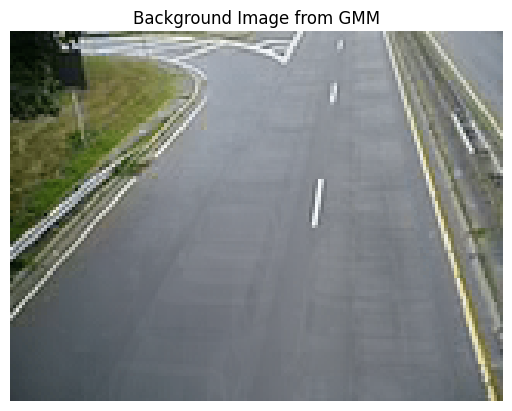

In [ ]:
height, width, channels = train_frames.shape[1], train_frames.shape[2], train_frames.shape[3]
background_image = np.zeros((height, width, channels))


from sklearn.mixture import GaussianMixture

for i in range(height):
    for j in range(width):
        pixel_values = train_frames[:, i, j, :]

        gmm = GaussianMixture2(n_components=2, covariance_type='full', random_state=0)
        gmm.fit(pixel_values)

        background_idx = np.argmax(gmm.weights_)
        background_color = gmm.means_[background_idx]

        background_image[i, j, :] = background_color

plt.imshow(background_image)
plt.title("Background Image from GMM")
plt.axis('off')
plt.show()



### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [ ]:

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2_imshow(frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

#### Frame Averaging

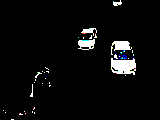

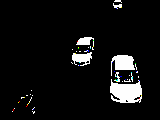

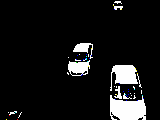

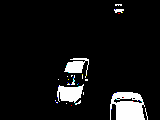

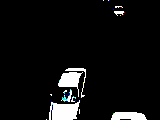

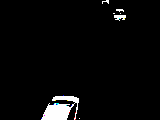

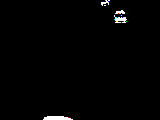

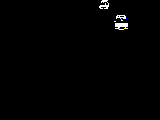

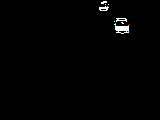

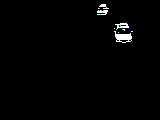

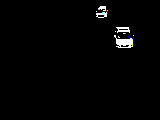

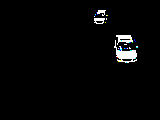

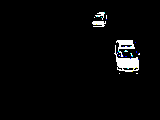

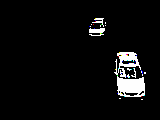

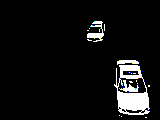

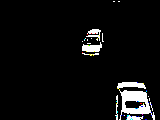

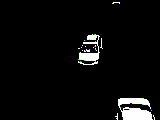

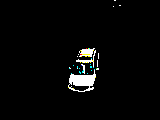

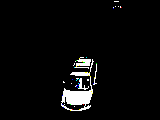

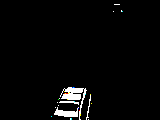

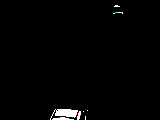

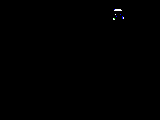

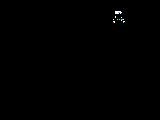

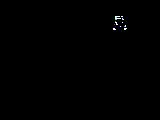

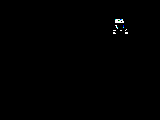

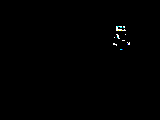

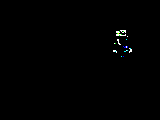

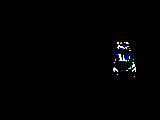

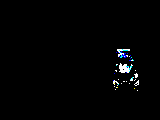

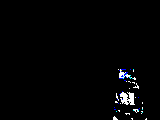

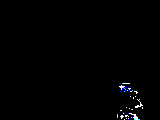

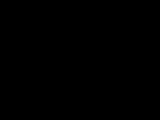

In [ ]:
# Initialize an array to hold the processed frames
processed_frames = np.zeros_like(test_frames)

for idx, frame in enumerate(test_frames):
    # Subtract the background image from the current frame
    # print(frame)
    diff = frame - background_image_frame_avg

    # Apply a threshold to highlight the foreground
    diff_threshold = np.where(diff > 0.2, 1, 0)  # Example threshold value, adjust as needed

    # Store the processed frame
    processed_frames[idx] = diff_threshold
save_frames(processed_frames, fps=10.0, output_path='./results', file_name='foreground_extraction_frame_avg')


#### GMMs per pixel

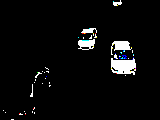

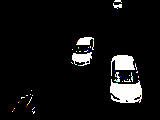

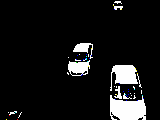

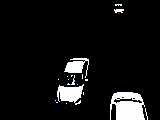

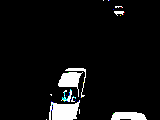

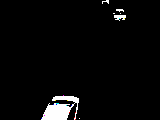

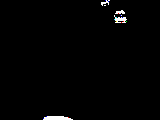

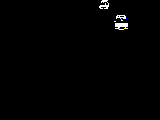

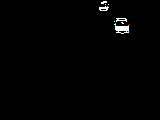

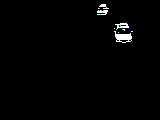

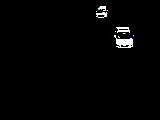

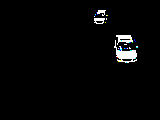

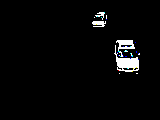

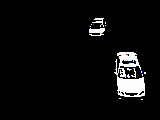

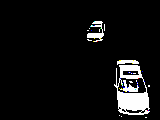

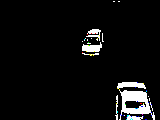

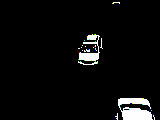

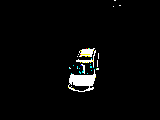

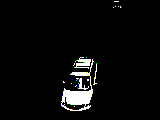

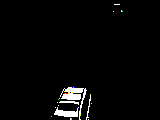

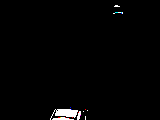

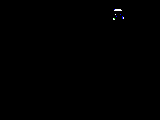

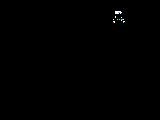

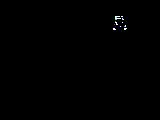

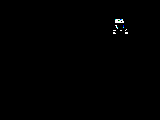

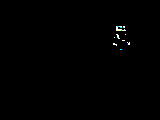

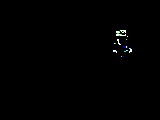

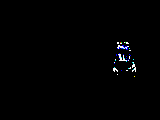

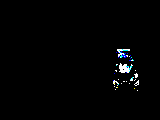

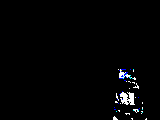

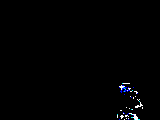

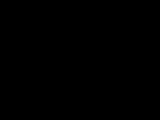

In [ ]:
# Initialize an array to hold the processed frames
processed_frames = np.zeros_like(test_frames)

for idx, frame in enumerate(test_frames):
    # Subtract the background image from the current frame
    diff = frame - background_image

    # Apply a threshold to highlight the foreground
    diff_threshold = np.where(diff > 0.2, 1, 0)  # Example threshold value, adjust as needed

    # Store the processed frame
    processed_frames[idx] = diff_threshold
save_frames(processed_frames, fps=10.0, output_path='./results', file_name='foreground_extraction_gmm')
